In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "code"))

In [2]:
import re
import json
import hydra
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf


import plotly.express as px

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches

from agent.option_critic import OptionCritic
from env.fourrooms import Fourrooms, LTLFourrooms

# Parameters

In [3]:
PATH = "logs"
DPI = 300

# Monitor

In [4]:
class Monitor:

    def __init__(self, path):
        
        self.path = path
        self.load()

    def load(self):
        
        self.names = os.listdir(self.path)
        self.configs = [json.load(open(os.path.join(PATH, name, "config.json"))) for name in self.names]
        self.configs = pd.json_normalize(self.configs)
        self.configs["name"] = self.names

        self.episode_logs = pd.DataFrame()
        for name in self.names:
            try:
                path = os.path.join(PATH, name, "episode.csv")
                episode_log = pd.read_csv(path)
            except:
                self.configs = self.configs[self.configs.name!=name]
                continue
                
            episode_log["name"] = name
            self.episode_logs = pd.concat([self.episode_logs, episode_log])

    def get_data(self, x, y, color, select, group=[]):

        data = self.configs.merge(self.episode_logs, how="inner", on="name")
        data = data[data["env.name"]==select]
        grouped_data = (
            data.groupby(group + [x])
            .agg({y: ["count", "mean", "min", "max", "std"]})
        )
        grouped_data.columns = grouped_data.columns.droplevel(0)
        grouped_data = grouped_data.reset_index()

        return grouped_data
        

    def plot(self, x, y, color, select, group=[], rolling_mean=None, x_range=None):

        grouped_data = self.get_data(x, y, color, select, group)

        if rolling_mean:
            grouped_data["mean"] = (
                grouped_data.groupby(group)["mean"].rolling(window=rolling_mean).mean().values
            )
        
        fig = px.line(
            data_frame=grouped_data,
            x=x,
            y="mean",
            color=color,
            labels={
                x: "Episode",
                "mean": "Reward",
            },
            template="ggplot2",
            width=3*DPI, height=1.2*DPI,
        )
        fig.update_layout(
            legend=dict(
                title= {'text': None},
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.83
        ))

        if x_range: fig.update_layout(xaxis_range=x_range)
            
        fig.show()
    
monitor = Monitor(PATH)

# Sapientino

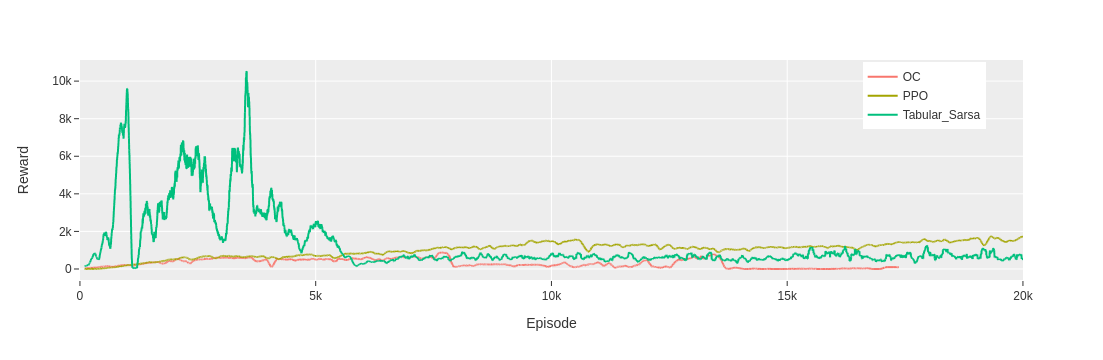

In [5]:
monitor.plot(
    x="episode", y="reward", color="agent.name", select="sapientino", group=["env.name", "agent.name"], rolling_mean=100)

# Breakout

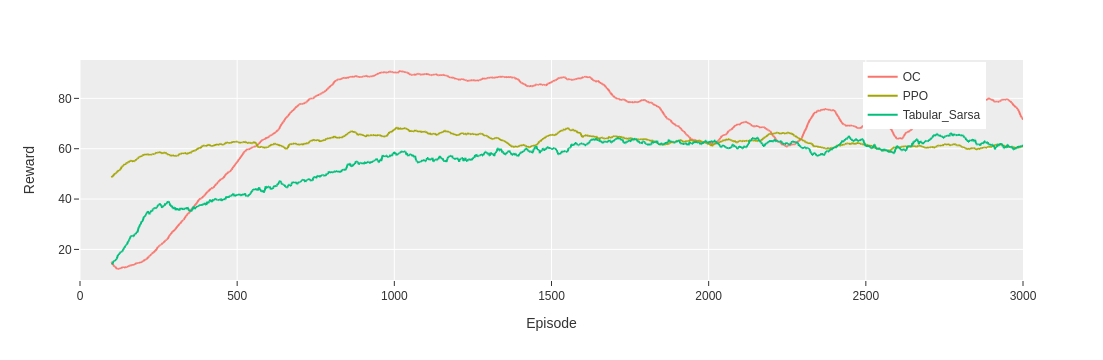

In [6]:
monitor.plot(x="episode", y="reward", color="agent.name", select="breakout", group=["env.name", "agent.name"], 
             rolling_mean=100, x_range=[0, 3000])

# Fourrroms
## Curves

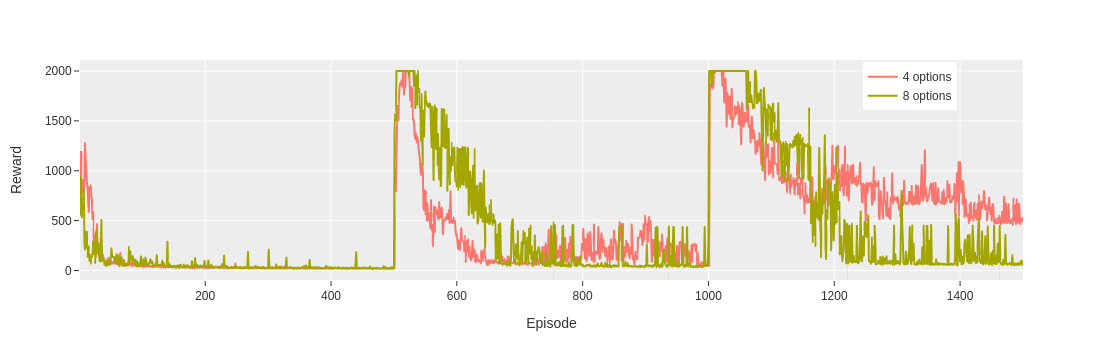

In [7]:
fourrooms_data = monitor.get_data(x="episode", y="ep_steps", color="agent.name", select="fourrooms", 
             group=["env.name", "agent.name", "agent.num_options"])

x_range = None
x = "episode"
group = ["env.name", "agent.name", "agent.num_options"]
rolling_mean = 1

fourrooms_data.loc[2:, "mean"] = (
    fourrooms_data.groupby(group + [pd.cut(fourrooms_data["episode"], np.arange(1, 1500+500, 500))])["mean"]
    .rolling(window=rolling_mean, min_periods=1).mean().values
)

fourrooms_data["agent.num_options"] = fourrooms_data["agent.num_options"].apply(lambda x: f"{int(x)} options")

fig = px.line(
    data_frame=fourrooms_data,
    x=x,
    y="mean",
    color="agent.num_options",
    labels={
        x: "Episode",
        "mean": "Reward",
    },
    template="ggplot2",
    width=3*DPI, height=1.2*DPI,
)
fig.update_layout(
    legend=dict(
        title= {'text': None},
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.83
))

if x_range: fig.update_layout(xaxis_range=x_range)
    
fig.show()

## Primary Policy

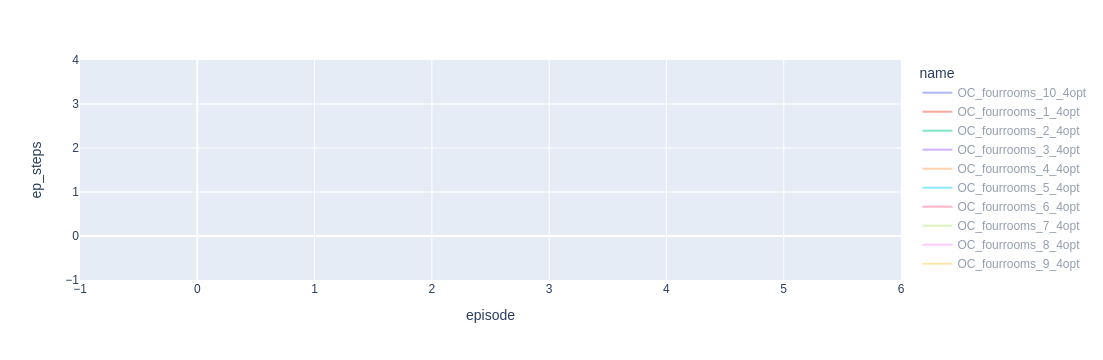

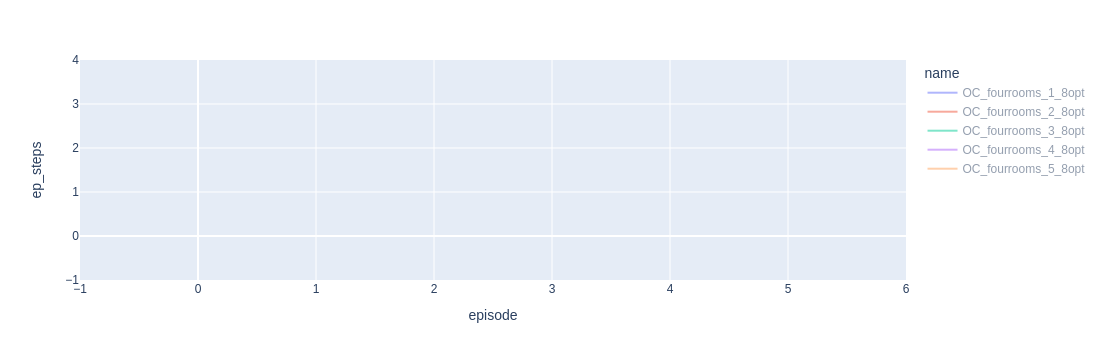

In [8]:
rolling_mean = 1
data = monitor.configs.merge(monitor.episode_logs, how="inner", on="name")
data = data[data["env.name"]=="fourrooms"]
# data = data[data["episode"]>1000]
grouped_data = (
    data.groupby(["name", "agent.num_options", "episode"])["ep_steps"]
    .rolling(window=rolling_mean, min_periods=1).mean()
    .reset_index()
)
fig = px.line(grouped_data[grouped_data["agent.num_options"]==4], x="episode", y="ep_steps", color='name')
fig.for_each_trace(lambda trace: trace.update(visible="legendonly") )
fig.show()

fig = px.line(grouped_data[grouped_data["agent.num_options"]==8], x="episode", y="ep_steps", color='name')
fig.for_each_trace(lambda trace: trace.update(visible="legendonly") )
fig.show()

In [10]:
env_states = 104
env_spec = 3
inter = 0.25 # Space between range of colors
color_pallete = mpl.colormaps["twilight"]
labels = ["s", "a", "b", "c"]
diffuse = True

model = torch.load("models/OC_fourrooms_1_4opt_ThirdStage")
cfg = OmegaConf.create(model["hyperparameters"])
env = LTLFourrooms(**cfg.env)
agent = OptionCritic(
        observation_space=env.observation_space, 
        action_space=env.action_space.n,
        args=cfg.agent
)
agent.option_critic.load_state_dict(model['model_params'])

handles = []
colors = []
for option_idx in range(cfg.agent.num_options):
    # Create handle: legend by option
    color = color_pallete((option_idx+1)/(cfg.agent.num_options + 1))
    colors.append(color)
    handle = patches.Patch(color=color, label=option_idx+1)
    handles.append(handle)

def plot_main_policy():
    fig, axs = plt.subplots(1, env_spec, figsize=(15, 5), layout='constrained')    
                
    for spec_idx in range(env_spec):
    
        # Adding the goals of the LTL spec
        for goal_idx in range(spec_idx+1):
            goal_label = re.match("x(.*?)y(.*)", env.spec.route[goal_idx])
            goal_cords = int(goal_label.group(1)), int(goal_label.group(2))
    
    
            circle = patches.Circle(goal_cords, radius=0.35, color='w')
            axs[spec_idx].add_patch(circle)
    
            axs[spec_idx].annotate(labels[goal_idx+1], goal_cords, color='b', 
                    fontsize=10, ha='center', va='center')
    
        # Adding the start position
        initial_location = env.tocell[env.init_states[0]]
        circle = patches.Circle(initial_location, radius=0.35, color='w')
        axs[spec_idx].add_patch(circle)
    
        axs[spec_idx].annotate("s", initial_location, color='b',
                fontsize=10, ha='center', va='center')
        
        map = env.occupancy.copy()*(cfg.agent.num_options + 1)
        map = map.astype(float)
    
        # Getting the values for the matrix for each state
        for env_idx in range(env_states):
            obs = torch.zeros(env.observation_space.shape[0])
            
            obs[env_idx] = 1
            obs[env_states+spec_idx]=1
    
            obs = torch.tensor(obs, dtype=torch.float32).to(agent.device)
            state = agent.option_critic.get_state(obs)
            logits = agent.option_critic.Q(obs)
            probs = logits.softmax(dim=-1)
            prob = probs.max()
            option = probs.argmax(dim=-1)
            
            # greedy_option  = agent.option_critic.greedy_option(state)
        #     action, logp, entropy = option_critic.get_action(state, greedy_option)
    
            pos = list(env.tocell[env_idx])
            map[pos[0], pos[1]] =  (option + prob + 1).item()
    
        #  Diffuse color for each option
        for option_idx in range(cfg.agent.num_options):
    
            # Create diffuse color
            if diffuse:
                mask = np.where((map>=option_idx+1) & (map<option_idx+2))
                if map[mask].size != 0:
                    max_ = map[mask].max()
                    min_ = map[mask].min()
                    slope = 2*inter/(max_-min_)
                    map[mask] = map[mask]*slope#
                    map[mask] = map[mask]-map[mask].min()
                    map[mask] = map[mask] + option_idx + 1 - inter # 0.25
            
        # Plot Grid
        matrice = axs[spec_idx].matshow(map, vmin=-0, vmax=cfg.agent.num_options + 1, cmap=color_pallete)
        axs[spec_idx].tick_params(left = False, bottom = False, top=False)
        axs[spec_idx].set_yticklabels([])
        axs[spec_idx].set_xticklabels([])
    
    fig.tight_layout(pad=5.0)
    print(handles)
    fig.legend(handles=handles, fancybox=True, framealpha=1, borderpad=1, loc="outside right upper", title="Option:")
    plt.savefig('options_activation.png')

plot_main_policy()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
def eval_model(name):
    
    model = torch.load(f"models/{name}_ThirdStage")
    cfg = OmegaConf.create(model["hyperparameters"])
    env = LTLFourrooms(**cfg.env)
    agent = OptionCritic(
            observation_space=env.observation_space, 
            action_space=env.action_space.n,
            args=cfg.agent
    )
    agent.option_critic.load_state_dict(model['model_params'])
    
    obs, info = env.reset()
    state = agent.option_critic.get_state(obs)
    greedy_option  = agent.option_critic.greedy_option(state)
    
    current_option = 0
    curr_op_len = 0
    ep_steps = 0
    ep_reward = 0
    option_termination = True
    epsilon = 0
    done = False
    truncated = False
    
    option_trace = []
    spec_trace = []    

    
    
    while not(done or truncated):
        
        if option_termination:
            current_option = np.random.choice(agent.num_options) if np.random.rand() < epsilon else greedy_option
    
        # ACTION
        action, logp, entropy, probs = agent.option_critic.get_action(state, current_option)
    
        # STEP
        next_obs, reward, done, truncated, _ = env.step(action)
        ep_reward += reward 
    
        # NEXT STATE
        state = agent.option_critic.get_state(next_obs)
    
        # OPTION TERMINATION
        option_termination, greedy_option = agent.option_critic.predict_option_termination(
            state, current_option)
        
        ep_steps += 1
        curr_op_len += 1
        obs = next_obs
        option_trace.append(current_option+1)
        spec_trace.append(env.spec.state)

    log = pd.DataFrame({"option_trace": option_trace, "spec_trace": spec_trace})
    return log

eval_data = pd.DataFrame()
names = monitor.configs[monitor.configs["env.name"]=="fourrooms"].name.unique()

for name in names:
    eval_log = eval_model(names[0])
    eval_log["name"] = name
    eval_data = pd.concat([eval_data, eval_log])

eval_data.groupby(["name"])["option_trace"].count().sort_values()

In [ ]:
color_discrete_map = {1: '#7FD4C1', 2: '#30BFDD', 3: '#8690FF', 4: '#ACD0F4'}

In [ ]:
def get_partitions(trace):
    # Paritions traces 00001111122223333
    
    current = trace[0]
    start = 0
    
    partitions = pd.DataFrame()
    for i, value in enumerate(trace):
        if value!=current or i==len(trace)-1:   
            partition = pd.DataFrame([{"option": str(current), "start": start+1, "end": i, "duration": i-start}])
            partitions = pd.concat([partitions, partition])
            
            start = i
            current = value

    partitions = partitions.reset_index(drop=True)
    return partitions

name = "OC_fourrooms_1_4opt"

# PARTITION OPTIONS
options_trace = eval_data[eval_data["name"]==name]["option_trace"]
options_partitions = get_partitions(options_trace)
## Fill for empty options
options_partitions = (
    options_partitions.sort_values("option").set_index("option")
    .reindex(list(map(str, range(1, agent.num_options+1)))).reset_index()
)
display(options_partitions)

# PARTITION SPEC STATE
spec_trace = eval_data[eval_data["name"]==name]["spec_trace"]
spec_partitions = get_partitions(spec_trace)
display(spec_partitions)

In [ ]:
'#{:02x}{:02x}{:02x}'.format(*colors[0][0:3])

In [ ]:
matplotlib.colors.to_hex(colors[0])

In [ ]:
np.array(colors[0][0:3])

In [ ]:
{str(i+1): colors[i] for i in range(len(colors))}

In [ ]:
fig = px.bar(
    options_partitions, base="start", x="duration", y="option", orientation='h', color="option",
    color_discrete_map = {str(i+1): matplotlib.colors.to_hex(colors[i]) for i in range(len(colors))},
    labels={"option":"Option", "duration": "Episode"},
    template="ggplot2",
    width=3.5*DPI, height=1*DPI
)

text_cords = []
spec_text = [] 
for i, spec_idx in spec_partitions.iterrows():

    
    fig.add_shape(
        type="line",
        x0=spec_idx["end"], y0=-0.5, x1=spec_idx["end"], y1=4.5,
        line=dict(
            color="black",
            width=2,
            dash="dashdot",
        )
    )

    cord = (spec_idx["end"]-spec_idx["start"])/2 + spec_idx["start"]
    fig.add_annotation(
            x=cord, y=4,
            text=f"State {i + 1}",
            showarrow=False,
                      )
    text_cords.append(cord)
    spec_text.append(f"State {i + 1}")


fig.update_layout(
    legend=dict(
        title= {'text': "Option: "},
        borderwidth=1,
        # x=0.94,
        # y=0.54,
        yanchor="top",
        xanchor="left",  
        # font=dict(
        #     family="Courier",
        #     size=12,
        #     color="black"
        # ),
))

fig.write_image('options_timeline.png')
fig.show()